#Bibliotecas

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.models import resnet50
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

#Montando o Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Configurações e paths necessários

In [3]:
# Configurações
SAVE_PATH = "/content/drive/My Drive/Sistemas Mecatrônicos/Cibernética e Aprendizagem de Máquinas/Projeto2/processed_data2"
MODEL_SAVE_PATH = "/content/drive/My Drive/Sistemas Mecatrônicos/Cibernética e Aprendizagem de Máquinas/Projeto2/saved_models2"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_LIDAR_POINTS = 124000  # Número fixo de pontos para nuvens de pontos
POSE_DIM = 6  # Supondo que as poses tenham 6 valores

#ResNET50


In [4]:
# Modelo ResNet50 para imagens
resnet_model = resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 128)
resnet_model = resnet_model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


#PointNET

In [5]:
# Modelo PointNet (Simplificado)
class PointNet(nn.Module):
    def __init__(self, output_dim=128):
        super(PointNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Shape: (batch_size, num_points, 128)
        x = torch.max(x, dim=1)[0]  # Max pooling → Shape: (batch_size, 128)
        return x

pointnet_model = PointNet().to(DEVICE)

#Função para o modelo de Fusão dos resultados das redes

In [17]:
# Modelo de combinação de características
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.fc1 = nn.Linear(128 * 2, 256)  # Combina recursos de imagem e LiDAR
        self.fc2 = nn.Linear(256, 128)
        self.fc_final = nn.Linear(128, 16)  # 🔹 Adicione essa linha para prever a matriz 4x4

    def forward(self, image_features, lidar_features):
        combined_features = torch.cat((image_features, lidar_features), dim=1)
        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        x = self.fc_final(x)  # 🔹 Última camada para prever 16 valores
        return x.view(-1, 4, 4)  # 🔹 Ajusta a forma para (batch_size, 4, 4)

fusion_model = FusionModel().to(DEVICE)

#Função de normalização de poses

In [7]:
# Função de normalização de poses
def normalize_poses(poses):
    min_vals, _ = torch.min(poses, dim=0, keepdim=True)
    max_vals, _ = torch.max(poses, dim=0, keepdim=True)
    return 2 * (poses - min_vals) / (max_vals - min_vals) - 1

#Função de perda e otimizadores

In [8]:
# Função de perda
criterion = nn.MSELoss()
optimizer = optim.Adam(
    list(resnet_model.parameters()) + list(pointnet_model.parameters()) + list(fusion_model.parameters()),
    lr=LEARNING_RATE
)

#Corrigindo nuvens com variação de quantidade de pontos

In [13]:
def process_lidar(lidar_data, num_points=NUM_LIDAR_POINTS):
    processed_lidar = []
    for points in lidar_data:
        points = np.array(points)

        if points.shape[0] > num_points:
            indices = np.random.choice(points.shape[0], num_points, replace=False)
            sampled_points = points[indices]
        else:
            pad = np.zeros((num_points - points.shape[0], 3))  # Preenchimento com zeros
            sampled_points = np.vstack((points, pad))

        processed_lidar.append(torch.tensor(sampled_points, dtype=torch.float32))

    return torch.stack(processed_lidar)  # Agora todas as nuvens têm o mesmo tamanho

# Função para carregar dados

In [12]:
def load_data_in_batches(is_train=True):
    data_type = "train" if is_train else "test"
    sequences = range(8) if is_train else range(8, 11)

    for seq in sequences:
        sequence = f"{seq:02d}"
        file_path = os.path.join(SAVE_PATH, f"{data_type}_{sequence}.pkl")

        if not os.path.exists(file_path):
            print(f"⚠️ Arquivo {file_path} não encontrado, pulando...")
            continue

        print(f"\n🔹 Carregando dados da sequência {sequence}...")

        with open(file_path, "rb") as f:
            data = pickle.load(f)

        images = [torch.tensor(img, dtype=torch.float32) for img in data["images"]]
        lidar = process_lidar(data["lidar"])  # 🔹 Agora processamos a nuvem de pontos corretamente
        poses = torch.tensor(data["poses"], dtype=torch.float32)

        images = torch.stack(images)  # Empilha imagens

        dataset = TensorDataset(images, lidar, poses)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

        yield dataloader  # Retorna o DataLoader da sequência atual

#Função de treinamento

In [19]:
# Treinamento
def train():
    for seq in range(8):
        sequence = f"{seq:02d}"
        print(f"\n🟢 Iniciando treinamento da sequência {sequence}")

        for epoch in range(EPOCHS):
            print(f"\n🔹 Iniciando Epoch {epoch + 1}/{EPOCHS} para sequência {sequence}")

            resnet_model.train()
            pointnet_model.train()
            fusion_model.train()
            total_loss = 0

            train_loader = next(load_data_in_batches(is_train=True))
            for images, lidar_points, poses in tqdm(train_loader, desc=f"Treinando Seq {sequence} - Epoch {epoch + 1}"):
                images, lidar_points, poses = images.to(DEVICE), lidar_points.to(DEVICE), poses.to(DEVICE)

                image_features = resnet_model(images)
                lidar_features = pointnet_model(lidar_points)
                predicted_poses = fusion_model(image_features, lidar_features)

                loss = criterion(predicted_poses, poses)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                del images, lidar_points, poses, image_features, lidar_features, predicted_poses
                torch.cuda.empty_cache()

            print(f"✅ Epoch {epoch + 1} para Seq {sequence} finalizada. Perda: {total_loss:.4f}")

            # Salvar modelos
            torch.save(resnet_model.state_dict(), os.path.join(MODEL_SAVE_PATH, f"resnet_seq_{sequence}_epoch_{epoch+1}.pth"))
            torch.save(pointnet_model.state_dict(), os.path.join(MODEL_SAVE_PATH, f"pointnet_seq_{sequence}_epoch_{epoch+1}.pth"))
            torch.save(fusion_model.state_dict(), os.path.join(MODEL_SAVE_PATH, f"fusion_seq_{sequence}_epoch_{epoch+1}.pth"))
            print(f"💾 Modelos salvos para Seq {sequence}, Epoch {epoch + 1}")

        # Liberar memória antes da próxima sequência
        del train_loader
        gc.collect()

#Executando o treinamento

In [20]:
train()


🟢 Iniciando treinamento da sequência 00

🔹 Iniciando Epoch 1/10 para sequência 00

🔹 Carregando dados da sequência 00...


<ipython-input-12-36d5be38f1a0>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = [torch.tensor(img, dtype=torch.float32) for img in data["images"]]
Treinando Seq 00 - Epoch 1: 100%|██████████| 284/284 [00:33<00:00,  8.43it/s]


✅ Epoch 1 para Seq 00 finalizada. Perda: 648603.3580
💾 Modelos salvos para Seq 00, Epoch 1

🔹 Iniciando Epoch 2/10 para sequência 00

🔹 Carregando dados da sequência 00...


Treinando Seq 00 - Epoch 2: 100%|██████████| 284/284 [00:33<00:00,  8.43it/s]


✅ Epoch 2 para Seq 00 finalizada. Perda: 532973.0281
💾 Modelos salvos para Seq 00, Epoch 2

🔹 Iniciando Epoch 3/10 para sequência 00

🔹 Carregando dados da sequência 00...


Treinando Seq 00 - Epoch 3: 100%|██████████| 284/284 [00:37<00:00,  7.59it/s]


✅ Epoch 3 para Seq 00 finalizada. Perda: 458633.7886
💾 Modelos salvos para Seq 00, Epoch 3

🔹 Iniciando Epoch 4/10 para sequência 00

🔹 Carregando dados da sequência 00...


Treinando Seq 00 - Epoch 4: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 4 para Seq 00 finalizada. Perda: 357619.6456
💾 Modelos salvos para Seq 00, Epoch 4

🔹 Iniciando Epoch 5/10 para sequência 00

🔹 Carregando dados da sequência 00...


Treinando Seq 00 - Epoch 5: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 5 para Seq 00 finalizada. Perda: 231515.2773
💾 Modelos salvos para Seq 00, Epoch 5

🔹 Iniciando Epoch 6/10 para sequência 00

🔹 Carregando dados da sequência 00...


Treinando Seq 00 - Epoch 6: 100%|██████████| 284/284 [00:37<00:00,  7.65it/s]


✅ Epoch 6 para Seq 00 finalizada. Perda: 142161.3318
💾 Modelos salvos para Seq 00, Epoch 6

🔹 Iniciando Epoch 7/10 para sequência 00

🔹 Carregando dados da sequência 00...


Treinando Seq 00 - Epoch 7: 100%|██████████| 284/284 [00:37<00:00,  7.64it/s]


✅ Epoch 7 para Seq 00 finalizada. Perda: 100180.1980
💾 Modelos salvos para Seq 00, Epoch 7

🔹 Iniciando Epoch 8/10 para sequência 00

🔹 Carregando dados da sequência 00...


Treinando Seq 00 - Epoch 8: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 8 para Seq 00 finalizada. Perda: 80491.2501
💾 Modelos salvos para Seq 00, Epoch 8

🔹 Iniciando Epoch 9/10 para sequência 00

🔹 Carregando dados da sequência 00...


Treinando Seq 00 - Epoch 9: 100%|██████████| 284/284 [00:37<00:00,  7.65it/s]


✅ Epoch 9 para Seq 00 finalizada. Perda: 64064.1159
💾 Modelos salvos para Seq 00, Epoch 9

🔹 Iniciando Epoch 10/10 para sequência 00

🔹 Carregando dados da sequência 00...


Treinando Seq 00 - Epoch 10: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 10 para Seq 00 finalizada. Perda: 53526.5006
💾 Modelos salvos para Seq 00, Epoch 10

🟢 Iniciando treinamento da sequência 01

🔹 Iniciando Epoch 1/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 1: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 1 para Seq 01 finalizada. Perda: 48532.4069
💾 Modelos salvos para Seq 01, Epoch 1

🔹 Iniciando Epoch 2/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 2: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 2 para Seq 01 finalizada. Perda: 40444.1356
💾 Modelos salvos para Seq 01, Epoch 2

🔹 Iniciando Epoch 3/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 3: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 3 para Seq 01 finalizada. Perda: 32475.3777
💾 Modelos salvos para Seq 01, Epoch 3

🔹 Iniciando Epoch 4/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 4: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 4 para Seq 01 finalizada. Perda: 26250.1849
💾 Modelos salvos para Seq 01, Epoch 4

🔹 Iniciando Epoch 5/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 5: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 5 para Seq 01 finalizada. Perda: 21743.2344
💾 Modelos salvos para Seq 01, Epoch 5

🔹 Iniciando Epoch 6/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 6: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 6 para Seq 01 finalizada. Perda: 15203.6914
💾 Modelos salvos para Seq 01, Epoch 6

🔹 Iniciando Epoch 7/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 7: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 7 para Seq 01 finalizada. Perda: 13486.4676
💾 Modelos salvos para Seq 01, Epoch 7

🔹 Iniciando Epoch 8/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 8: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 8 para Seq 01 finalizada. Perda: 59232.2326
💾 Modelos salvos para Seq 01, Epoch 8

🔹 Iniciando Epoch 9/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 9: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 9 para Seq 01 finalizada. Perda: 23874.3065
💾 Modelos salvos para Seq 01, Epoch 9

🔹 Iniciando Epoch 10/10 para sequência 01

🔹 Carregando dados da sequência 00...


Treinando Seq 01 - Epoch 10: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 10 para Seq 01 finalizada. Perda: 11023.4279
💾 Modelos salvos para Seq 01, Epoch 10

🟢 Iniciando treinamento da sequência 02

🔹 Iniciando Epoch 1/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 1: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 1 para Seq 02 finalizada. Perda: 8165.1113
💾 Modelos salvos para Seq 02, Epoch 1

🔹 Iniciando Epoch 2/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 2: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 2 para Seq 02 finalizada. Perda: 6432.1899
💾 Modelos salvos para Seq 02, Epoch 2

🔹 Iniciando Epoch 3/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 3: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 3 para Seq 02 finalizada. Perda: 5641.4629
💾 Modelos salvos para Seq 02, Epoch 3

🔹 Iniciando Epoch 4/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 4: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 4 para Seq 02 finalizada. Perda: 4815.3309
💾 Modelos salvos para Seq 02, Epoch 4

🔹 Iniciando Epoch 5/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 5: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 5 para Seq 02 finalizada. Perda: 5518.7978
💾 Modelos salvos para Seq 02, Epoch 5

🔹 Iniciando Epoch 6/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 6: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 6 para Seq 02 finalizada. Perda: 4105.6070
💾 Modelos salvos para Seq 02, Epoch 6

🔹 Iniciando Epoch 7/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 7: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 7 para Seq 02 finalizada. Perda: 4236.7550
💾 Modelos salvos para Seq 02, Epoch 7

🔹 Iniciando Epoch 8/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 8: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 8 para Seq 02 finalizada. Perda: 69740.8886
💾 Modelos salvos para Seq 02, Epoch 8

🔹 Iniciando Epoch 9/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 9: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 9 para Seq 02 finalizada. Perda: 16752.9408
💾 Modelos salvos para Seq 02, Epoch 9

🔹 Iniciando Epoch 10/10 para sequência 02

🔹 Carregando dados da sequência 00...


Treinando Seq 02 - Epoch 10: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 10 para Seq 02 finalizada. Perda: 5561.4262
💾 Modelos salvos para Seq 02, Epoch 10

🟢 Iniciando treinamento da sequência 03

🔹 Iniciando Epoch 1/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 1: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 1 para Seq 03 finalizada. Perda: 4216.2946
💾 Modelos salvos para Seq 03, Epoch 1

🔹 Iniciando Epoch 2/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 2: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 2 para Seq 03 finalizada. Perda: 3232.4203
💾 Modelos salvos para Seq 03, Epoch 2

🔹 Iniciando Epoch 3/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 3: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 3 para Seq 03 finalizada. Perda: 3232.9868
💾 Modelos salvos para Seq 03, Epoch 3

🔹 Iniciando Epoch 4/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 4: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 4 para Seq 03 finalizada. Perda: 2472.9785
💾 Modelos salvos para Seq 03, Epoch 4

🔹 Iniciando Epoch 5/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 5: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 5 para Seq 03 finalizada. Perda: 2691.2717
💾 Modelos salvos para Seq 03, Epoch 5

🔹 Iniciando Epoch 6/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 6: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 6 para Seq 03 finalizada. Perda: 3262.4232
💾 Modelos salvos para Seq 03, Epoch 6

🔹 Iniciando Epoch 7/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 7: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 7 para Seq 03 finalizada. Perda: 3296.9000
💾 Modelos salvos para Seq 03, Epoch 7

🔹 Iniciando Epoch 8/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 8: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 8 para Seq 03 finalizada. Perda: 3022.7914
💾 Modelos salvos para Seq 03, Epoch 8

🔹 Iniciando Epoch 9/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 9: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 9 para Seq 03 finalizada. Perda: 3017.4084
💾 Modelos salvos para Seq 03, Epoch 9

🔹 Iniciando Epoch 10/10 para sequência 03

🔹 Carregando dados da sequência 00...


Treinando Seq 03 - Epoch 10: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 10 para Seq 03 finalizada. Perda: 2528.2473
💾 Modelos salvos para Seq 03, Epoch 10

🟢 Iniciando treinamento da sequência 04

🔹 Iniciando Epoch 1/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 1: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 1 para Seq 04 finalizada. Perda: 3514.7667
💾 Modelos salvos para Seq 04, Epoch 1

🔹 Iniciando Epoch 2/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 2: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 2 para Seq 04 finalizada. Perda: 2729.1072
💾 Modelos salvos para Seq 04, Epoch 2

🔹 Iniciando Epoch 3/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 3: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 3 para Seq 04 finalizada. Perda: 45870.1853
💾 Modelos salvos para Seq 04, Epoch 3

🔹 Iniciando Epoch 4/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 4: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 4 para Seq 04 finalizada. Perda: 14505.1984
💾 Modelos salvos para Seq 04, Epoch 4

🔹 Iniciando Epoch 5/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 5: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 5 para Seq 04 finalizada. Perda: 3704.5572
💾 Modelos salvos para Seq 04, Epoch 5

🔹 Iniciando Epoch 6/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 6: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 6 para Seq 04 finalizada. Perda: 2868.9893
💾 Modelos salvos para Seq 04, Epoch 6

🔹 Iniciando Epoch 7/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 7: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 7 para Seq 04 finalizada. Perda: 2403.8509
💾 Modelos salvos para Seq 04, Epoch 7

🔹 Iniciando Epoch 8/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 8: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 8 para Seq 04 finalizada. Perda: 1865.2497
💾 Modelos salvos para Seq 04, Epoch 8

🔹 Iniciando Epoch 9/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 9: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 9 para Seq 04 finalizada. Perda: 2083.1540
💾 Modelos salvos para Seq 04, Epoch 9

🔹 Iniciando Epoch 10/10 para sequência 04

🔹 Carregando dados da sequência 00...


Treinando Seq 04 - Epoch 10: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 10 para Seq 04 finalizada. Perda: 1629.5440
💾 Modelos salvos para Seq 04, Epoch 10

🟢 Iniciando treinamento da sequência 05

🔹 Iniciando Epoch 1/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 1: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 1 para Seq 05 finalizada. Perda: 1538.9563
💾 Modelos salvos para Seq 05, Epoch 1

🔹 Iniciando Epoch 2/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 2: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 2 para Seq 05 finalizada. Perda: 2207.9668
💾 Modelos salvos para Seq 05, Epoch 2

🔹 Iniciando Epoch 3/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 3: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 3 para Seq 05 finalizada. Perda: 1633.5465
💾 Modelos salvos para Seq 05, Epoch 3

🔹 Iniciando Epoch 4/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 4: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 4 para Seq 05 finalizada. Perda: 1881.9752
💾 Modelos salvos para Seq 05, Epoch 4

🔹 Iniciando Epoch 5/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 5: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 5 para Seq 05 finalizada. Perda: 1460.9234
💾 Modelos salvos para Seq 05, Epoch 5

🔹 Iniciando Epoch 6/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 6: 100%|██████████| 284/284 [00:37<00:00,  7.65it/s]


✅ Epoch 6 para Seq 05 finalizada. Perda: 1303.8573
💾 Modelos salvos para Seq 05, Epoch 6

🔹 Iniciando Epoch 7/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 7: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 7 para Seq 05 finalizada. Perda: 1654.9022
💾 Modelos salvos para Seq 05, Epoch 7

🔹 Iniciando Epoch 8/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 8: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 8 para Seq 05 finalizada. Perda: 1527.2778
💾 Modelos salvos para Seq 05, Epoch 8

🔹 Iniciando Epoch 9/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 9: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 9 para Seq 05 finalizada. Perda: 48484.5188
💾 Modelos salvos para Seq 05, Epoch 9

🔹 Iniciando Epoch 10/10 para sequência 05

🔹 Carregando dados da sequência 00...


Treinando Seq 05 - Epoch 10: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 10 para Seq 05 finalizada. Perda: 5131.0737
💾 Modelos salvos para Seq 05, Epoch 10

🟢 Iniciando treinamento da sequência 06

🔹 Iniciando Epoch 1/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 1: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 1 para Seq 06 finalizada. Perda: 2304.1948
💾 Modelos salvos para Seq 06, Epoch 1

🔹 Iniciando Epoch 2/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 2: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 2 para Seq 06 finalizada. Perda: 1751.0854
💾 Modelos salvos para Seq 06, Epoch 2

🔹 Iniciando Epoch 3/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 3: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 3 para Seq 06 finalizada. Perda: 1456.5476
💾 Modelos salvos para Seq 06, Epoch 3

🔹 Iniciando Epoch 4/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 4: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 4 para Seq 06 finalizada. Perda: 1915.7768
💾 Modelos salvos para Seq 06, Epoch 4

🔹 Iniciando Epoch 5/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 5: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 5 para Seq 06 finalizada. Perda: 1503.4396
💾 Modelos salvos para Seq 06, Epoch 5

🔹 Iniciando Epoch 6/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 6: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 6 para Seq 06 finalizada. Perda: 1160.7689
💾 Modelos salvos para Seq 06, Epoch 6

🔹 Iniciando Epoch 7/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 7: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 7 para Seq 06 finalizada. Perda: 1690.7544
💾 Modelos salvos para Seq 06, Epoch 7

🔹 Iniciando Epoch 8/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 8: 100%|██████████| 284/284 [00:37<00:00,  7.65it/s]


✅ Epoch 8 para Seq 06 finalizada. Perda: 1346.7465
💾 Modelos salvos para Seq 06, Epoch 8

🔹 Iniciando Epoch 9/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 9: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 9 para Seq 06 finalizada. Perda: 1462.3845
💾 Modelos salvos para Seq 06, Epoch 9

🔹 Iniciando Epoch 10/10 para sequência 06

🔹 Carregando dados da sequência 00...


Treinando Seq 06 - Epoch 10: 100%|██████████| 284/284 [00:37<00:00,  7.65it/s]


✅ Epoch 10 para Seq 06 finalizada. Perda: 988.9503
💾 Modelos salvos para Seq 06, Epoch 10

🟢 Iniciando treinamento da sequência 07

🔹 Iniciando Epoch 1/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 1: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 1 para Seq 07 finalizada. Perda: 1309.5286
💾 Modelos salvos para Seq 07, Epoch 1

🔹 Iniciando Epoch 2/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 2: 100%|██████████| 284/284 [00:37<00:00,  7.67it/s]


✅ Epoch 2 para Seq 07 finalizada. Perda: 1352.4916
💾 Modelos salvos para Seq 07, Epoch 2

🔹 Iniciando Epoch 3/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 3: 100%|██████████| 284/284 [00:37<00:00,  7.63it/s]


✅ Epoch 3 para Seq 07 finalizada. Perda: 1070.6427
💾 Modelos salvos para Seq 07, Epoch 3

🔹 Iniciando Epoch 4/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 4: 100%|██████████| 284/284 [00:37<00:00,  7.64it/s]


✅ Epoch 4 para Seq 07 finalizada. Perda: 5583.3984
💾 Modelos salvos para Seq 07, Epoch 4

🔹 Iniciando Epoch 5/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 5: 100%|██████████| 284/284 [00:37<00:00,  7.66it/s]


✅ Epoch 5 para Seq 07 finalizada. Perda: 26215.3356
💾 Modelos salvos para Seq 07, Epoch 5

🔹 Iniciando Epoch 6/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 6: 100%|██████████| 284/284 [00:37<00:00,  7.65it/s]


✅ Epoch 6 para Seq 07 finalizada. Perda: 2238.5401
💾 Modelos salvos para Seq 07, Epoch 6

🔹 Iniciando Epoch 7/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 7: 100%|██████████| 284/284 [00:37<00:00,  7.65it/s]


✅ Epoch 7 para Seq 07 finalizada. Perda: 1490.2752
💾 Modelos salvos para Seq 07, Epoch 7

🔹 Iniciando Epoch 8/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 8: 100%|██████████| 284/284 [00:37<00:00,  7.65it/s]


✅ Epoch 8 para Seq 07 finalizada. Perda: 1103.4318
💾 Modelos salvos para Seq 07, Epoch 8

🔹 Iniciando Epoch 9/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 9: 100%|██████████| 284/284 [00:37<00:00,  7.64it/s]


✅ Epoch 9 para Seq 07 finalizada. Perda: 1129.6898
💾 Modelos salvos para Seq 07, Epoch 9

🔹 Iniciando Epoch 10/10 para sequência 07

🔹 Carregando dados da sequência 00...


Treinando Seq 07 - Epoch 10: 100%|██████████| 284/284 [00:37<00:00,  7.65it/s]


✅ Epoch 10 para Seq 07 finalizada. Perda: 997.6467
💾 Modelos salvos para Seq 07, Epoch 10


# Carregar os modelos salvos

In [29]:
# Carregar os modelos salvos
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Função de avaliação

In [93]:
# Função de avaliação
def evaluate():
    # Carregar os modelos salvos para a sequência atual e última época (10)
    resnet_model = resnet50(pretrained=False)
    resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 128)
    resnet_model = load_model(resnet_model, os.path.join(MODEL_SAVE_PATH, f"resnet_seq_06_epoch_10.pth"))

    # Mover o modelo para o dispositivo correto (GPU ou CPU)
    resnet_model = resnet_model.to(DEVICE)

    pointnet_model = PointNet().to(DEVICE)  # Mover o modelo para o dispositivo
    pointnet_model = load_model(pointnet_model, os.path.join(MODEL_SAVE_PATH, f"pointnet_seq_06_epoch_10.pth"))

    fusion_model = FusionModel().to(DEVICE)  # Mover o modelo para o dispositivo
    fusion_model = load_model(fusion_model, os.path.join(MODEL_SAVE_PATH, f"fusion_seq_06_epoch_10.pth"))

    all_losses = []
    predicted_poses_list = []
    ground_truth_poses_list = []

    # Para cada sequência de teste (08, 09, 10)
    for seq in range(8, 11):
        sequence = f"{seq:02d}"
        print(f"\n🔹 Iniciando avaliação da sequência {sequence}")

        test_loader = next(load_data_in_batches(is_train=False))
        total_loss = 0

        with torch.no_grad():  # Não é necessário calcular gradientes
            for images, lidar_points, poses in tqdm(test_loader, desc=f"Avaliando Seq {sequence}"):

                images, lidar_points, poses = images.to(DEVICE), lidar_points.to(DEVICE), poses.to(DEVICE)

                image_features = resnet_model(images)  # As imagens já estão no dispositivo
                lidar_features = pointnet_model(lidar_points)
                predicted_poses = fusion_model(image_features, lidar_features)

                loss = criterion(predicted_poses, poses)
                total_loss += loss.item()

                # Armazenar as previsões e as poses reais para posterior comparação
                predicted_poses_list.append(predicted_poses.cpu().numpy())
                ground_truth_poses_list.append(poses.cpu().numpy())

        avg_loss = total_loss / len(test_loader)
        print(f"✅ Avaliação da sequência {sequence} concluída. Perda média: {avg_loss:.4f}")
        all_losses.append(avg_loss/100)

        # Limpar memória
        del test_loader
        torch.cuda.empty_cache()

    # Plotando as perdas médias de cada sequência de teste
    plt.figure(figsize=(10, 5))
    plt.plot(range(8, 11), all_losses, marker='o', linestyle='-', color='b')
    plt.title("Average Loss per Test Sequence")
    plt.xlabel("Sequences")
    plt.ylabel("Average Losses")
    plt.grid(True)
    plt.show()

    # Plotando uma comparação entre as poses previstas e as reais
    predicted_poses_flat = np.concatenate(predicted_poses_list, axis=0)
    # print("predic poses: ")
    # print(predicted_poses_flat)
    # print("dados plotados: ")
    # print(predicted_poses_flat[:, 0])
    # print("parte2: ")
    # print(predicted_poses_flat[:, 1])
    ground_truth_poses_flat = np.concatenate(ground_truth_poses_list, axis=0)
    # print("ground truth: ")
    # print(ground_truth_poses_flat)
    # print("dados plotados: ")
    # print(ground_truth_poses_flat[:, 0])
    # print("parte2: ")
    # print(ground_truth_poses_flat[:, 1])

    # Calcular o erro total
    error = []
    for i in range(len(predicted_poses_flat)):
        error.append(total_error(predicted_poses_flat[i], ground_truth_poses_flat[i]))
    print("Numero total: ")
    print(len(error))
    print(f"Erro total: {error}")

    plt.figure(figsize=(10, 5))
    plt.plot(predicted_poses_flat[:, 0], predicted_poses_flat[:, 1], label='Poses previstas', color='r')
    plt.plot(ground_truth_poses_flat[:, 0], ground_truth_poses_flat[:, 1], label='Poses reais', color='g', linestyle='--')
    plt.title("Comparação entre as poses previstas e as reais (Plano XY)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

#Rodando Avaliação

<ipython-input-29-358e3faa9793>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



🔹 Iniciando avaliação da sequência 08

🔹 Carregando dados da sequência 08...


<ipython-input-12-36d5be38f1a0>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = [torch.tensor(img, dtype=torch.float32) for img in data["images"]]
Avaliando Seq 08: 100%|██████████| 255/255 [00:10<00:00, 23.27it/s]


✅ Avaliação da sequência 08 concluída. Perda média: 4936.7212

🔹 Iniciando avaliação da sequência 09

🔹 Carregando dados da sequência 08...


Avaliando Seq 09: 100%|██████████| 255/255 [00:10<00:00, 23.26it/s]


✅ Avaliação da sequência 09 concluída. Perda média: 4925.2051

🔹 Iniciando avaliação da sequência 10

🔹 Carregando dados da sequência 08...


Avaliando Seq 10: 100%|██████████| 255/255 [00:10<00:00, 23.24it/s]


✅ Avaliação da sequência 10 concluída. Perda média: 4933.4432


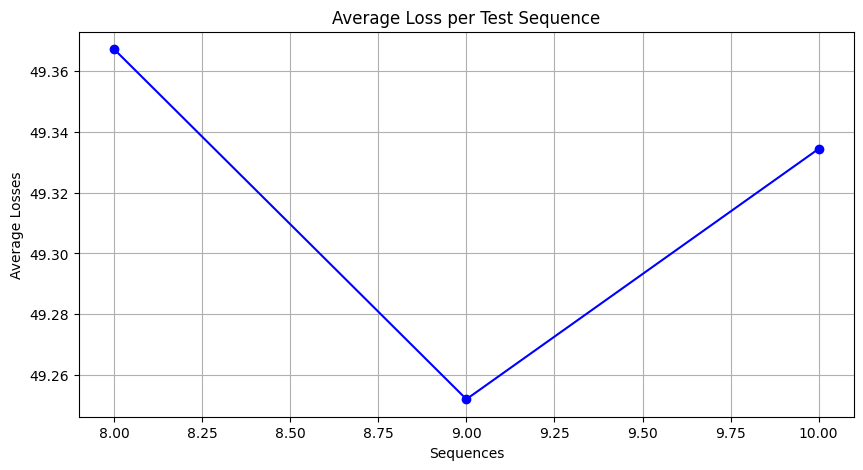

<ipython-input-77-9f8922080a0b>:4: RuntimeWarning: invalid value encountered in arccos
  error_angle = np.arccos((trace - 1) / 2)


Numero total: 
12213
Erro total: [[1.592986930635591, 96.3456], [2.14746750239856, 378.80615], [1.5963072293707459, 243.95744], [1.9615704095476267, 88.47783], [nan, 290.10947], [1.6827390641377937, 182.91782], [0.7287689215626613, 141.90523], [nan, 252.75172], [1.2637616959341202, 507.7285], [nan, 146.69945], [2.0098182792663195, 101.17501], [1.606893466510045, 584.6554], [1.8183044663407093, 476.65146], [1.9193824146551188, 177.68164], [0.8435703661417113, 184.25706], [2.2520068279701535, 469.61533], [1.2975660563275193, 153.92928], [2.4299171576893013, 174.77927], [1.817689179479415, 128.5762], [1.567406127315183, 177.96591], [2.373825353127474, 274.43604], [1.141906181685907, 367.11893], [nan, 143.17627], [2.4033144485826354, 82.8613], [0.9077371193810901, 215.25359], [nan, 279.2199], [nan, 210.12492], [0.9469735192343898, 230.52277], [2.472687108276361, 208.72076], [nan, 243.79735], [0.8672676198299115, 57.413628], [1.4586244326682476, 240.68416], [2.961192528498031, 170.23352], [

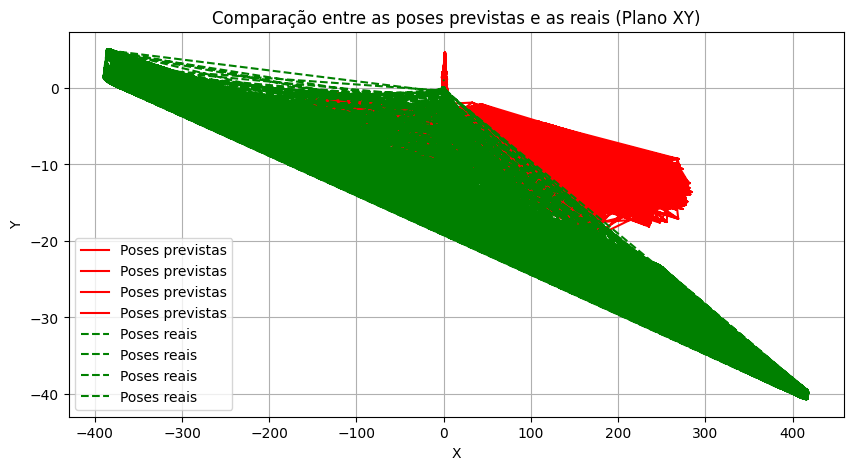

In [100]:
evaluate()

In [77]:
def rotation_error(R_real, R_calculada):
    # Calcula o erro de rotação (ângulo entre as duas matrizes de rotação)
    trace = np.trace(np.dot(R_real.T, R_calculada))
    error_angle = np.arccos((trace - 1) / 2)
    return error_angle

def translation_error(t_real, t_calculada):
    # Calcula a distância euclidiana entre as translações
    return np.linalg.norm(t_real - t_calculada)

def total_error(T_real, T_calculada):
    # Extrai rotação e translação das matrizes 4x4
    R_real = T_real[:3, :3]
    t_real = T_real[:3, 3]
    R_calculada = T_calculada[:3, :3]
    t_calculada = T_calculada[:3, 3]

    # Erro de rotação e translação
    rotation_err = rotation_error(R_real, R_calculada)
    translation_err = translation_error(t_real, t_calculada)

    # Erro total (norma combinada)
    # total_err = np.sqrt(rotation_err**2 + translation_err**2)
    total_err = [rotation_err, translation_err]
    return total_err

#Gráfico de losses vs épocas (criado manual)

<ipython-input-52-53481fb5465a>:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


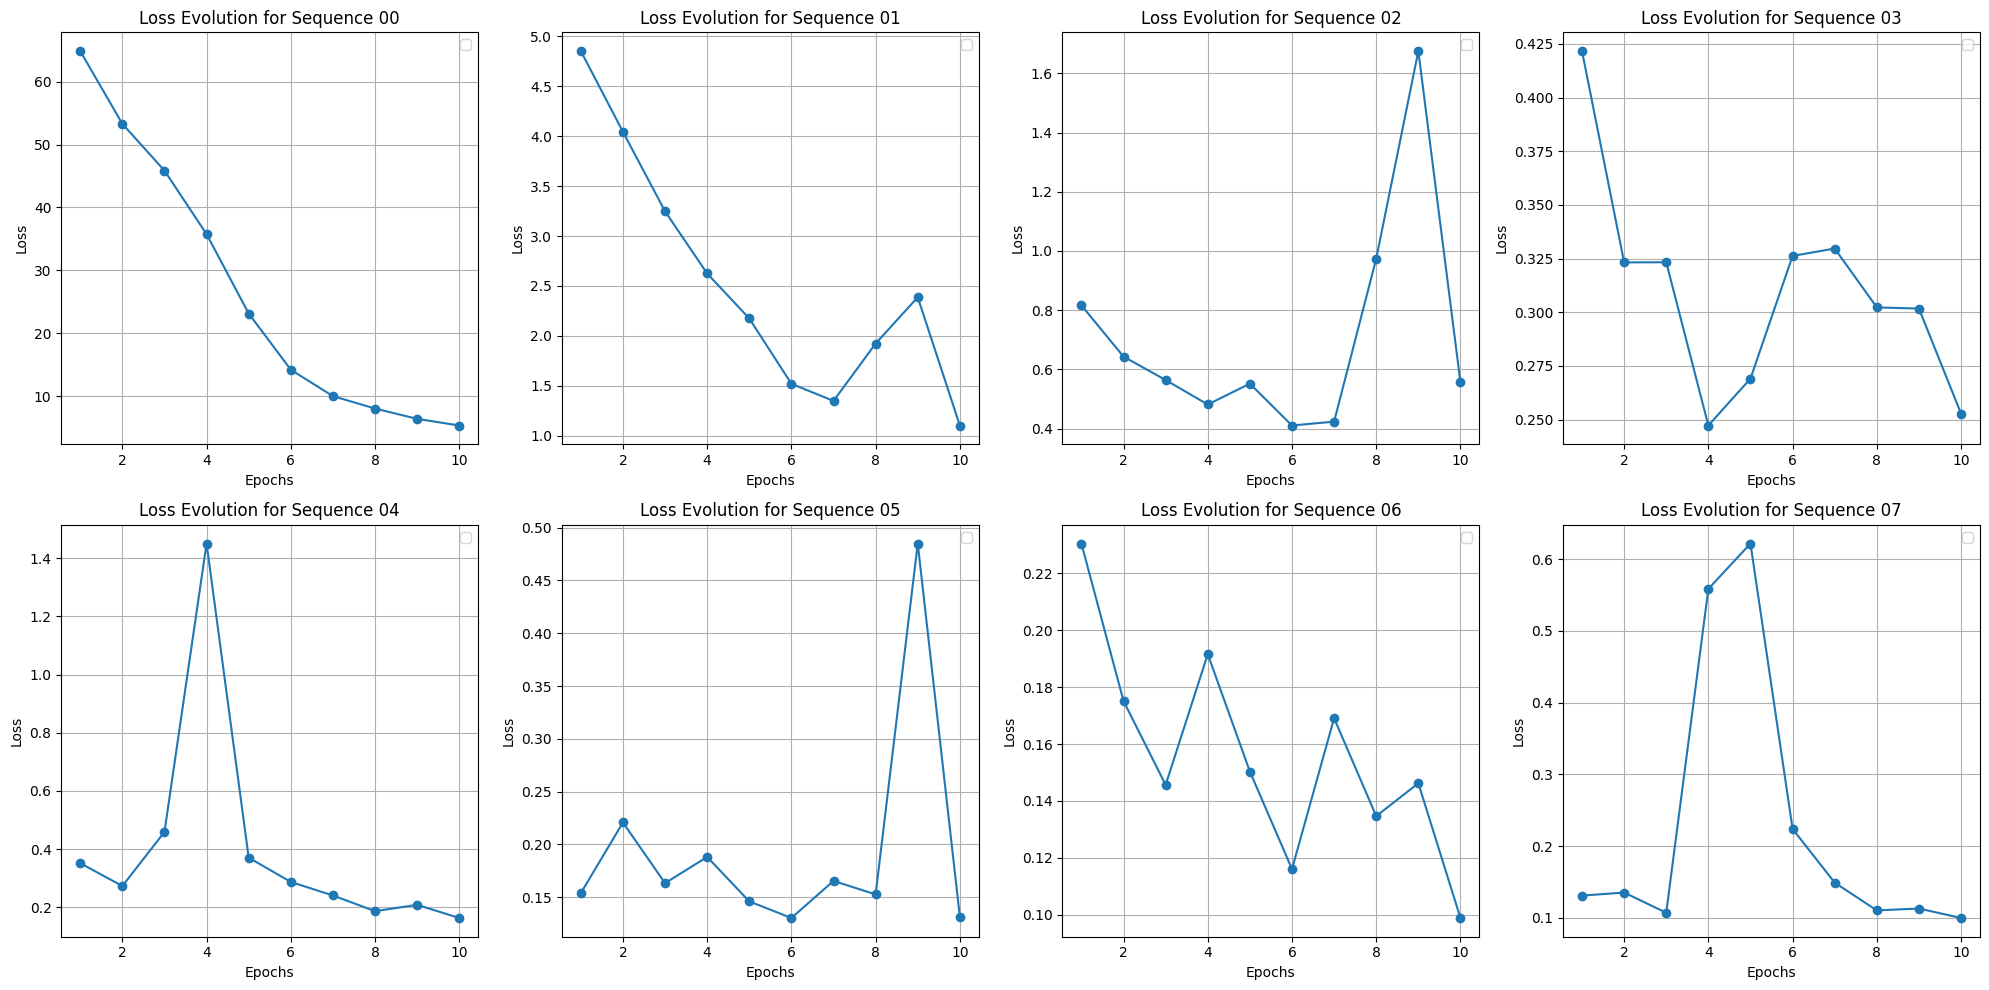

In [52]:
import matplotlib.pyplot as plt

epocas = list(range(1, 11))
seqs = ["00", "01", "02", "03", "04", "05", "06", "07"]
seq_losses = [
    [648603.3580, 532973.0281, 458633.7886, 357619.6456, 231515.2773, 142161.3318, 100180.1980, 80491.2501, 64064.1159, 53526.5006],
    [48532.4069, 40444.1356, 32475.3777, 26250.1849, 21743.2344, 15203.6914, 13486.4676, 19232.2326, 23874.3065, 11023.4279],
    [8165.1113, 6432.1899, 5641.4629, 4815.3309, 5518.7978, 4105.6070, 4236.7550, 9740.8886, 16752.9408, 5561.4262],
    [4216.2946, 3232.4203, 3232.9868, 2472.9785, 2691.2717, 3262.4232, 3296.9000, 3022.7914, 3017.4084, 2528.2473],
    [3514.7667, 2729.1072, 4587.1853, 14505.1984, 3704.5572, 2868.9893, 2403.8509, 1865.2497, 2083.1540, 1629.5440],
    [1538.9563, 2207.9668, 1633.5465, 1881.9752, 1460.9234, 1303.8573, 1654.9022, 1527.2778, 4848.5188, 1315.0737],
    [2304.1948, 1751.0854, 1456.5476, 1915.7768, 1503.4396, 1160.7689, 1690.7544, 1346.7465, 1462.3845, 988.9503],
    [1309.5286, 1352.4916, 1070.6427, 5583.3984, 6215.3356, 2238.5401, 1490.2752, 1103.4318, 1129.6898, 997.6467]
]

# Dividir todos os valores por 1000
seq_losses = [[loss / 10000 for loss in seq] for seq in seq_losses]

# Número de linhas e colunas para a grade de subplots
nrows = 2  # Ajuste conforme necessário
ncols = 4  # Ajuste conforme necessário

# Criando a grade de subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))  # Ajuste o tamanho da figura conforme necessário

# Aplanando a matriz de eixos para facilitar a iteração
axes = axes.flatten()

# Plotando cada curva em seu próprio subplot
for i, seq in enumerate(seqs):
    ax = axes[i]  # Seleciona o subplot atual
    ax.plot(epocas, seq_losses[i], marker='o', linestyle='-')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(f"Loss Evolution for Sequence {seq}")
    ax.legend()
    ax.grid()

# Ajusta o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exibe o gráfico
plt.show()

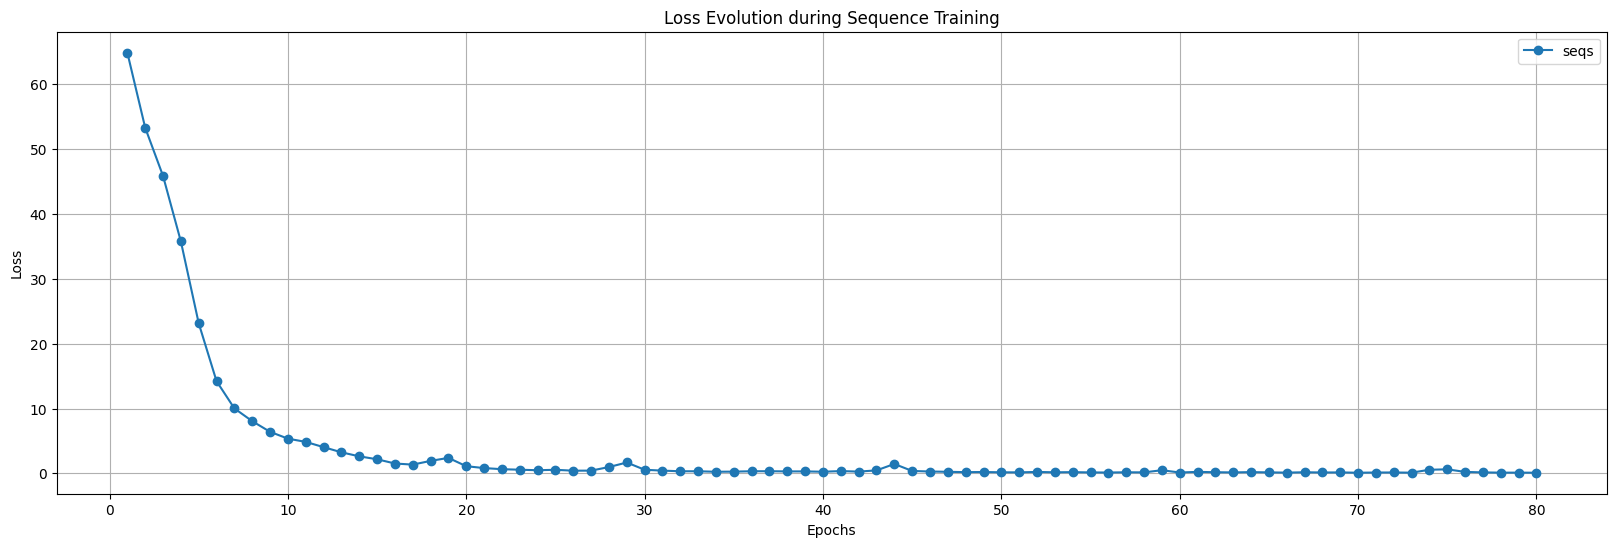

In [54]:
import matplotlib.pyplot as plt

epocas = list(range(1, 81))
seqs = ["00", "01", "02", "03", "04", "05", "06", "07"]
seq_losses = [
    648603.3580, 532973.0281, 458633.7886, 357619.6456, 231515.2773, 142161.3318, 100180.1980, 80491.2501, 64064.1159, 53526.5006,
    48532.4069, 40444.1356, 32475.3777, 26250.1849, 21743.2344, 15203.6914, 13486.4676, 19232.2326, 23874.3065, 11023.4279,
    8165.1113, 6432.1899, 5641.4629, 4815.3309, 5518.7978, 4105.6070, 4236.7550, 9740.8886, 16752.9408, 5561.4262,
    4216.2946, 3232.4203, 3232.9868, 2472.9785, 2691.2717, 3262.4232, 3296.9000, 3022.7914, 3017.4084, 2528.2473,
    3514.7667, 2729.1072, 4587.1853, 14505.1984, 3704.5572, 2868.9893, 2403.8509, 1865.2497, 2083.1540, 1629.5440,
    1538.9563, 2207.9668, 1633.5465, 1881.9752, 1460.9234, 1303.8573, 1654.9022, 1527.2778, 4848.5188, 1315.0737,
    2304.1948, 1751.0854, 1456.5476, 1915.7768, 1503.4396, 1160.7689, 1690.7544, 1346.7465, 1462.3845, 988.9503,
    1309.5286, 1352.4916, 1070.6427, 5583.3984, 6215.3356, 2238.5401, 1490.2752, 1103.4318, 1129.6898, 997.6467
]

# Dividir todos os valores por 1000
seq_losses = [loss / 10000 for loss in seq_losses]

# Criando o gráfico
plt.figure(figsize=(20, 6))
x = epocas

# Plotando cada curva
plt.plot(x, seq_losses, label="seqs", marker='o', linestyle='-')

# Adicionando título e rótulos aos eixos
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Evolution during Sequence Training")
plt.legend()
plt.grid()
plt.show()